# Research Assistant

Till now we have studied
* Memory
* Human-in-the-loop
* Controllability

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o",temperature=0)

## Generate Analysts: Human-in-The-Loop

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

# Define the Analyst Class
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

# Define a class containing info about all the Analysts
# Useful for getting structured outputs from the llm
class Perspectives(BaseModel):
    analysts: list[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations."
    )

# Define the state for the subgraph
class GenerateAnalystsState(TypedDict):
    topic: str # Input from the user
    max_analysts: int # Number of Analyst
    human_analyst_feedback: str # Human Feedback
    analysts: List[Analyst] # Analysts asking questions 

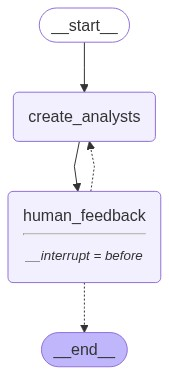

In [29]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

# Define the function to create analysts
def create_analysts(state: GenerateAnalystsState):
    """Create Analysts"""

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforcing Structured Outputs
    structured_llm = llm.with_structured_output(Perspectives)

    # System Message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)
    
    # Generate the Analysts
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

# For the Human Feedback, we will use a no-op node so that we can interrupt
def human_feedback(state: GenerateAnalystsState):
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the Next Node to execute"""

    # If any human feedback is there, return back to create_analysts node
    human_feedback = state.get('human_analyst_feedback', None)
    if human_feedback:
        return "create_analysts"
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [30]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and integration capabilities of LangGraph. She is particularly interested in how LangGraph can enhance the efficiency and scalability of AI systems.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: GreenTech Solutions
Role: Sustainability Analyst
Description: Mr. Patel examines the environmental impact of adopting LangGraph. He is concerned with how the framework can contribute to energy efficiency and reduce the carbon footprint of AI operations.
--------------------------------------------------
Name: Ms. Linda Zhao
Affiliation: Global Business Insights
Role: Business Strategist
Description: Ms. Zhao analyzes the economic benefits and market potential of LangGraph. Her focus is on how adopting this framework can provide competitive advantages and drive business growth.
------------------------------------

In [31]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [32]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f052d9c-eb85-6a0f-8002-01decdb9704b'}}

In [33]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and integration capabilities of LangGraph. She is particularly interested in how LangGraph can enhance the efficiency and scalability of AI systems.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: GreenTech Solutions
Role: Sustainability Analyst
Description: Mr. Patel examines the environmental impact of adopting LangGraph. He is concerned with how the framework can contribute to energy efficiency and reduce the carbon footprint of AI operations.
--------------------------------------------------
Name: Ms. Linda Zhao
Affiliation: Global Business Insights
Role: Business Strategist
Description: Ms. Zhao analyzes the economic benefits and market potential of LangGraph. Her focus is on how adopting this framework can provide competitive advantages and drive business growth.
------------------------------------

In [34]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f052d9d-2ac1-63b6-8004-1f0d645b2d85'}}

In [35]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [36]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [37]:
final_state.next

()

In [38]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Alex Johnson
Affiliation: Tech Startup
Role: Entrepreneur
Description: Alex is a co-founder of a tech startup that specializes in AI-driven solutions. He is focused on the practical applications and scalability of adopting LangGraph as an agent framework, particularly in how it can drive innovation and competitive advantage for startups.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: University of Technology
Role: Academic Researcher
Description: Dr. Chen is a leading researcher in AI frameworks and their impact on computational efficiency. Her focus is on the theoretical benefits of LangGraph, such as improved processing speeds and resource management, and how these can be leveraged in academic and industrial research.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Global Tech Corporation
Role: Industry Expert
Description: Michael is a senior software engineer at a major tech corporation. He is interes

## Conduct Interviews
- Multi-turn Conversation between our Analysts and `Experts`: Agents with access to data sources!

In [7]:
from operator import add
from typing import Annotated
from langgraph.graph.message import MessagesState

# State for Conducting Interviews
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

# For Structured Output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

Flow:
- The `Analyst` generates a question based on it's persona and topic/sub-topic in consideration
- The `Expert` analyzes the question and makes relevant tool calls with proper `query`
- The Analyst and Expert converse until the Analyst is satified.

In [57]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is to boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals and information about you: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answers: Parallelization

- We will give our `Expert` some tools which it can use parallely
- From the question presented by our Analyst, make a query for tool call

#### Search Tools - Tavily, Wikipedia

In [58]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

from langchain_community.document_loaders import WikipediaLoader

In [59]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

# Make the tools for searching the web based on the query
def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

#### Nodes to Answer the question, Save the interview, and The Router

In [60]:
# Node to answer the question posed by analyst based on the Retrieved Context

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    """Node to answer a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Generate Answer
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Tag the message as coming from the Expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

# Node to save the interview
def save_interview(state: InterviewState):
    
    """ Save the interview once over """
    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

# Router
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "generate_question"

#### Node to Create a Summary of The Interview

In [61]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    """ Node to Generate the summary/ section report """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

#### Compile the Conduct Interview Graph

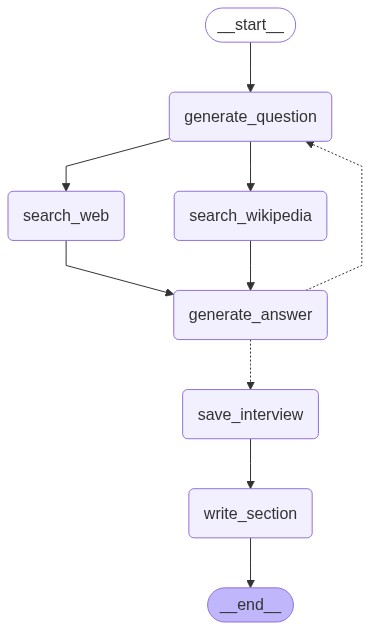

In [62]:
interview_builder = StateGraph(InterviewState)
# Add Nodes
interview_builder.add_node('generate_question',generate_question)
interview_builder.add_node('search_web',search_web)
interview_builder.add_node('search_wikipedia',search_wikipedia)
interview_builder.add_node('generate_answer',generate_answer)
interview_builder.add_node('save_interview',save_interview)
interview_builder.add_node('write_section',write_section)

# Add Edges
interview_builder.add_edge(START, 'generate_question')
interview_builder.add_edge('generate_question','search_web')
interview_builder.add_edge('generate_question','search_wikipedia')
interview_builder.add_edge('search_web','generate_answer')
interview_builder.add_edge('search_wikipedia','generate_answer')
interview_builder.add_conditional_edges('generate_answer',route_messages, 
                                        path_map={'save_interview':'save_interview',
                                                  'generate_question':'generate_question'})
interview_builder.add_edge('save_interview','write_section')
interview_builder.add_edge('write_section',END)

# Memory 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [63]:
interview_graph.config

{'run_name': 'Conduct Interviews', 'configurable': {}}

#### Sample Run

In [64]:
# Pick an Analyst
analysts[0]

Analyst(affiliation='Tech Startup', name='Alex Johnson', role='Entrepreneur', description='Alex is a co-founder of a tech startup that specializes in AI-driven solutions. He is focused on the practical applications and scalability of adopting LangGraph as an agent framework, particularly in how it can drive innovation and competitive advantage for startups.')

In [65]:
topic

'The benefits of adopting LangGraph as an agent framework'

In [66]:
from IPython.display import Markdown
messages = []
thread = {"configurable": {"thread_id": "2"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Leveraging LangGraph for AI-Driven Innovation in Startups

### Summary

In the rapidly evolving landscape of AI-driven solutions, selecting the right agent framework is crucial for startups aiming to gain a competitive edge. LangGraph emerges as a compelling choice, particularly for tech startups focused on practical applications and scalability. This report delves into the unique features of LangGraph and its potential to drive innovation and competitive advantage.

LangGraph is an AI agent framework that implements agent interactions as stateful graphs, where nodes represent functions or computational steps connected via edges. This architecture allows for the visualization of complex tasks and mapping out dependencies, making it ideal for structured workflows [1]. Unlike other frameworks, LangGraph supports the implementation of more complex agentic workflows, offering built-in persistence and support for various memory strategies to optimize token usage [2].

One of the novel aspects of LangGraph is its flexibility in using multiple large language models (LLMs) at different stages of the workflow. This allows the agent to select the most suitable LLM based on the current task, enhancing efficiency and effectiveness [3]. Additionally, LangGraph's graph-based architecture provides fine-grained control over the flow and state of agent applications, drawing inspiration from distributed computing models like Pregel and processing frameworks like Apache Beam [2].

The framework's design emphasizes stateful execution, allowing applications to maintain context across interactions. This is particularly beneficial for startups looking to build scalable and maintainable AI systems, as it ensures that AI initiatives are not just demos or one-off scripts but long-term strategic assets [4]. LangGraph also supports sandboxed code execution for safe evaluation of generated code, comprehensive error handling, and diagnostic logging, creating a development experience focused on building production-ready agent systems [2].

For startups, the ability to precisely control when and how agents interact is a significant advantage. LangGraph's nodes and edges act like a playbook, allowing for phases in the workflow where agents work in parallel, and points where the workflow pauses for decisions or input [4]. This capability can be leveraged to handle tasks that were once bottlenecks, thereby gaining an edge in customer responsiveness, data analysis, and innovation capacity.

In conclusion, LangGraph offers a robust framework for startups aiming to harness the power of AI agents. Its unique features and architecture provide the tools necessary to build scalable, efficient, and innovative AI-driven solutions, positioning startups for success in a competitive market.

### Sources
[1] https://oyelabs.com/langgraph-vs-crewai-vs-openai-swarm-ai-agent-framework/  
[2] https://developer.ibm.com/articles/awb-comparing-ai-agent-frameworks-crewai-langgraph-and-beeai/  
[3] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4  
[4] https://www.scalablepath.com/machine-learning/langgraph  

In [67]:
state = interview_graph.get_state(thread)
state

StateSnapshot(values={'messages': [AIMessage(content="Hello, I'm Alex Johnson, co-founder of a tech startup focused on AI-driven solutions. I'm particularly interested in understanding how adopting LangGraph as an agent framework can drive innovation and provide a competitive edge for startups like mine. Could you explain what makes LangGraph unique compared to other agent frameworks?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 227, 'total_tokens': 285, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run-2ba398c5-e380-49ce-a47e-da6afbb79b6f-0', usage_metadata={'input_tokens': 227, 'output_tokens': 58, 'total_tokens': 285}), AIMessage(conten

In [68]:
for m in state.values['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Hello, I'm Alex Johnson, co-founder of a tech startup focused on AI-driven solutions. I'm particularly interested in understanding how adopting LangGraph as an agent framework can drive innovation and provide a competitive edge for startups like mine. Could you explain what makes LangGraph unique compared to other agent frameworks?
================================== Ai Message ==================================
Name: expert

LangGraph stands out as an AI agent framework due to its graph-based architecture, which is particularly effective for visualizing complex tasks and mapping out dependencies. This makes it ideal for structured workflows, allowing for a clear representation of the interactions and processes involved in AI-driven solutions [1]. 

One of the key features of LangGraph is its implementation of agent interactions as stateful graphs, where nodes represent functions or computational steps con

## Using Map-Reduce for Interview Conduction

In [73]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [90]:
from langgraph.constants import Send

def initialize_all_interviews(state: ResearchGraphState):
    '''Node to Initialize all the Interviews once the Analysts are confirmed'''

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"
    
    topic = state['topic']
    message = HumanMessage(content=f'So you said you were writing an article on: {topic}')
    return [Send('conduct_interview', {'analyst':analyst, 'messages':[message]}) for analyst in state['analysts']]

### Master Report Writer

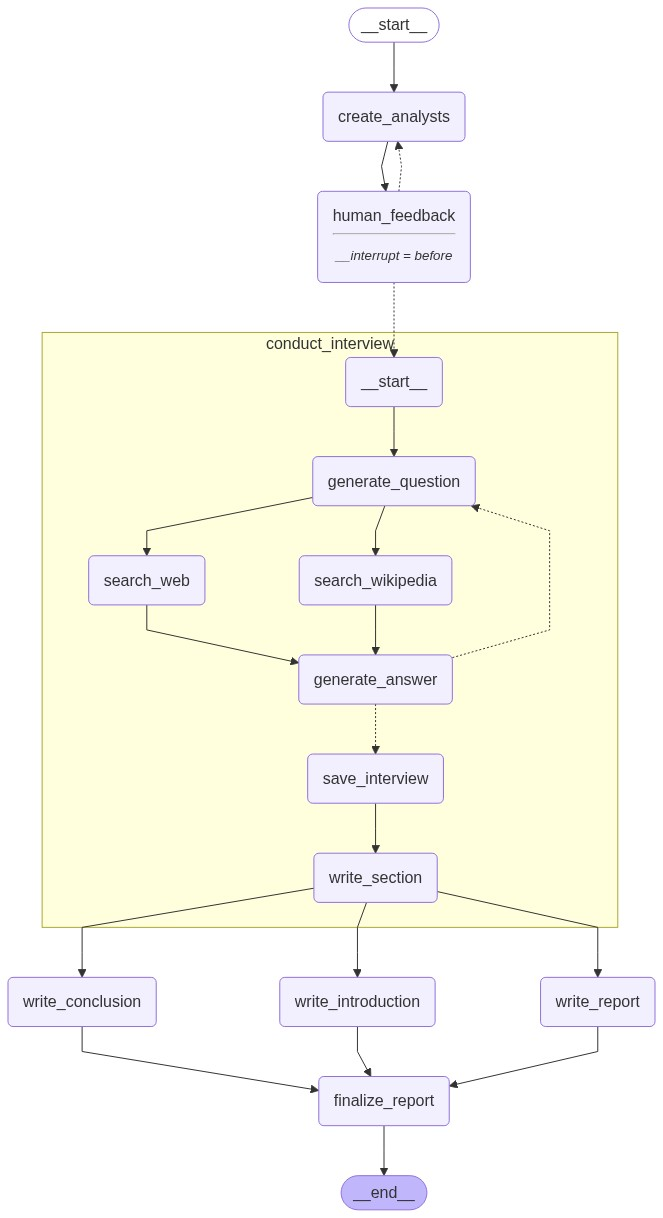

In [96]:
# Takes in all the sections and writes the complete compiled report
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.
9. In the whole content written, make sure to update the indexes of sources properly i.e [1],[2] must be repeated again in different paragraphs/ sections

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initialize_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png())) 

## Sample Run

In [97]:
# Inputs
max_analysts = 3 
topic = "The usefulness of LangGraph in upcoming era of AgenticAI"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Institute for Advanced AI Research
Role: AI Linguistics Specialist
Description: Dr. Carter focuses on the integration of LangGraph in enhancing natural language processing capabilities within AgenticAI systems. Her primary concern is ensuring that LangGraph can effectively handle the complexities of human language to improve AI communication and understanding.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Tech Innovations Lab
Role: AI Systems Architect
Description: Mr. Patel is interested in the structural and architectural implications of incorporating LangGraph into AgenticAI. He is motivated by the potential for LangGraph to streamline AI system design and improve efficiency in processing and decision-making.
--------------------------------------------------
Name: Dr. Sophia Nguyen
Affiliation: Global AI Ethics Consortium
Role: AI Ethics Analyst
Description: Dr. Nguyen examines the ethical considerations of u

In [98]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Make it more industry centric."}, as_node="human_feedback")
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Institute for Advanced AI Research
Role: AI Linguistics Specialist
Description: Dr. Carter focuses on the integration of LangGraph in enhancing natural language processing capabilities within AgenticAI systems. Her primary concern is ensuring that LangGraph can effectively handle the complexities of human language to improve AI communication and understanding.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Tech Innovations Lab
Role: AI Systems Architect
Description: Mr. Patel is interested in the structural and architectural implications of incorporating LangGraph into AgenticAI. He is motivated by the potential for LangGraph to streamline AI system design and improve efficiency in processing and decision-making.
--------------------------------------------------
Name: Dr. Sophia Nguyen
Affiliation: Global AI Ethics Consortium
Role: AI Ethics Analyst
Description: Dr. Nguyen examines the ethical considerations of u

In [99]:
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [102]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# LangGraph: Pioneering the Future of Agentic AI

## Introduction

In the rapidly advancing tech industry, LangGraph emerges as a transformative tool, poised to revolutionize AI-driven solutions. This report delves into LangGraph's potential to enhance operational efficiencies and drive innovation. By offering a structured framework for natural language processing, LangGraph excels in creating stateful, multi-actor applications with Large Language Models (LLMs). It orchestrates complex workflows, enabling parallel execution and decision-making. LangGraph's real-world applications span customer service, IoT integration, and more, showcasing its versatility. As we navigate the ethical landscape of AgenticAI, LangGraph's robust platform stands as a catalyst for advancing AI technologies, ensuring alignment with societal values.

---



LangGraph is emerging as a pivotal framework in the rapidly evolving landscape of AgenticAI, offering transformative capabilities for developing AI-driven solutions across various industries. As a high-level abstraction tool, LangGraph is designed to streamline the development of applications involving multiple AI agents, providing a structured framework for natural language processing and understanding. Its graph-based representation allows developers to define actors, their attributes, relationships, and behaviors, thereby simplifying and accelerating the development process [1]. This flexibility is crucial for creating stateful, multi-actor applications with Large Language Models (LLMs), which are essential for advanced chatbots and interactive AI systems [1].

One of LangGraph's most compelling features is its ability to orchestrate complex workflows involving multiple AI agents. By controlling when and how agents interact, LangGraph acts as a playbook, enabling parallel execution of tasks and decision-making processes. This capability enhances creativity and power in AI applications while maintaining the rigor and clarity of traditional software engineering [2]. Furthermore, LangGraph's growing ecosystem and active community contribute to its stability and adaptability, insulating solutions from the volatility of the AI vendor landscape [2].

The integration of LangGraph into AgenticAI systems also presents unique ethical considerations. As these systems allow LLMs to autonomously control application workflows, they introduce new ethical dilemmas, such as ensuring fairness, accountability, and transparency in decision-making processes [3]. The complexity and autonomy of these systems necessitate robust ethical guidelines to prevent misuse and ensure that they benefit humanity as a whole [3]. This includes implementing safeguards against potential misbehaviors, such as prompt injection attacks, and ensuring that AI systems do not perpetuate existing biases, particularly in sensitive areas like healthcare [5].

LangGraph's real-world applications are diverse and impactful. In customer service, AI-powered support agents built on LangGraph technology are transforming the industry by providing efficient and effective solutions, thereby enhancing operational capabilities and market competitiveness [3]. Additionally, LangGraph's integration with IoT devices creates smart environments that enhance automation and data collection, leading to significant operational efficiencies [3]. These applications demonstrate LangGraph's potential to revolutionize sectors such as finance, healthcare, and logistics by driving AI-driven solutions for risk management, patient care, and route optimization [3].

LangGraph's architecture, inspired by Pregel and Apache Beam, provides a graph-based design that allows for flexible node and edge connections, custom state management, and full control over agent interactions [1]. This flexibility is crucial for developing applications that require intricate workflows and real-time data processing. Its integration with LangChain further enhances its capabilities, allowing for seamless incorporation of language models into agentic workflows [1]. This integration is particularly beneficial for applications in conversational AI and natural language processing, where maintaining contextual coherence and structured task dependencies is essential [2].

Overall, LangGraph stands out as a powerful tool for advancing Agentic AI technologies, offering a comprehensive framework that supports the development of complex, stateful, and multi-agent applications. Its ability to integrate with other AI tools and frameworks, coupled with its flexible architecture, positions it as a catalyst for new AI applications and innovations in the technological landscape.


---

## Conclusion

LangGraph emerges as a pivotal framework in the evolving landscape of Agentic AI, offering transformative capabilities for developing multi-agent systems. Its high-level abstraction and graph-based design streamline the creation of stateful, interactive AI applications, enhancing operational efficiencies across industries. By orchestrating complex workflows and integrating with IoT devices, LangGraph drives innovation in sectors like customer service, finance, and healthcare. However, as it empowers AI systems with greater autonomy, it also necessitates robust ethical guidelines to ensure fairness, accountability, and transparency. As the tech industry advances, LangGraph's role in shaping AI-driven solutions will be indispensable.

## Sources
[1] https://www.linkedin.com/pulse/what-langgraph-how-useful-building-llm-based-sarfraz-nawaz-walic/  
[2] https://www.scalablepath.com/machine-learning/langgraph/  
[3] https://www.rapidinnovation.io/post/ai-agents-in-langgraph/  
[4] https://www.thoughtspot.com/data-trends/data-and-analytics-engineering/agentic-ai  
[5] https://medium.com/@adnanmasood/the-agentic-imperative-series-part-3-langchain-langgraph-building-dynamic-agentic-workflows-7184bad6b827